# Importing libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

torch.manual_seed(42)
np.random.seed(42)

# Our implementation of Compact Transformer Model

In [2]:
# MultiHeadAttention Module
class MSA(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=3, dropout: float=0):
        super().__init__()
        # layer normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # multiheadattention layer
        self.msa_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=dropout,
                                                   batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        # query, key, value are formed from the same x
        x, _ = self.msa_attention(query=x,
                                    key=x,
                                    value=x,
                                    need_weights=False)
        return x
    
# MLP layer   
class MLP(nn.Module):
    def __init__(self, 
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 dropout: float=0.1):
        super().__init__()
        # layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # two linear layers separated by GeLU activation
        self.mlp = nn.Sequential(
                nn.Linear(in_features=embedding_dim,
                        out_features=mlp_size), # from input_dim to mlp_size
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=mlp_size, # from mlp_size to input_dim
                        out_features=embedding_dim),
                nn.Dropout(p=dropout))
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x
        
# Transformer encoder block
class EncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=192,
                 num_heads: int=3,
                 mlp_size: int=768,
                 mlp_dropout: float=0.1,
                 msa_dropout: float=0.0):
        super().__init__()
        # each block (layer) consists of MSA and MLP
        self.msa = MSA(embedding_dim=embedding_dim,
                       num_heads=num_heads,
                       dropout=msa_dropout)
        
        self.mlp = MLP(embedding_dim=embedding_dim,
                       mlp_size=mlp_size,
                       dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa(x) + x # skip connection #1
        x = self.mlp(x) + x # skip connection #2
        
        return x


# taken from CVT-CCT paper
class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size: int=7, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding: int=1,
                 conv_layers: int=2, input_channels: int=3, 
                 output_channels: int=64, in_planes: int=64):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, in_planes,
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)
        
        self.max_pool = nn.MaxPool2d(kernel_size=pooling_kernel_size,
                                     stride=pooling_stride,
                                     padding=pooling_padding)
        
        self.conv2 = nn.Conv2d(in_planes, output_channels,
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.flatten(x)
        
        return x.permute(0, 2, 1)


class CvT(nn.Module):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__()
        
        self.tokenizer = Tokenizer(kernel_size=kernel_size, stride=stride, 
                                   padding=padding, pooling_kernel_size=pooling_kernel_size, 
                                   pooling_stride=pooling_stride, pooling_padding=pooling_padding, 
                                   conv_layers=conv_layers, input_channels=in_channels, 
                                   output_channels=embedding_dim, in_planes=in_planes)
        
        self.attention_pool = nn.Linear(embedding_dim, 1)
        
        self.emb_dropout = nn.Dropout(p=emb_dropout)
        
        self.encoder = nn.Sequential(*[
            EncoderBlock(embedding_dim=embedding_dim,
                         num_heads=num_heads,
                         mlp_size=mlp_size,
                         mlp_dropout=mlp_dropout,
                         msa_dropout=msa_dropout)
            for _ in range(layers)
        ])
        
        self.norm = nn.LayerNorm(embedding_dim)
        
        self.head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.tokenizer(x)
        x = self.emb_dropout(x)
        x = self.encoder(x)
        x = self.norm(x)
        x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
        x = self.head(x)
        
        return x
    
class CvT_3(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=3, embedding_dim: int=192, mlp_size: int=384,
                 num_heads: int=3, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_7(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_14(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=14, embedding_dim: int=384, mlp_size: int=1152,
                 num_heads: int=6, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)

# Setting up config Parameters

In [3]:
config = {
    'ROOT_DIR': r"C:\Users\fano2\Downloads\state-farm-distracted-driver-detection\imgs\train",
    'TEST_DIR': r"C:\Users\fano2\Downloads\state-farm-distracted-driver-detection\imgs\test",
    'MODELS_DIR': r'C:\Users\fano2',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 7,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 5e-3,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 0,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

# Utility Functions

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels


class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
def adjust_learning_rate(optimizer, epoch, warmup=False, warmup_ep=0, enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
def save_graphs(train, test, type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {type}")
    plt.plot(test,label="valid")
    plt.plot(train,label="train")
    plt.xlabel("Epoch")
    plt.ylabel(f"{type}")
    plt.legend()
    plt.savefig(f'{type}.png')

# Training Functions

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

# Model, Optimizer, Criterion

In [12]:
model = CvT_7()
model = model.to(config['DEVICE'])
model_name = "cvt_7"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

In [13]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
CvT_7 (CvT_7)                                           [32, 3, 224, 224]    [32, 10]             --                   True
├─Tokenizer (tokenizer)                                 [32, 3, 224, 224]    [32, 196, 256]       --                   True
│    └─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─MaxPool2d (max_pool)                             [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Conv2d (conv2)                                   [32, 64, 56, 56]     [32, 256, 28, 28]    802,816              True
│    └─MaxPool2d (max_pool)                             [32, 256, 28, 28]    [32, 256, 14, 14]    --                   --
│    └─Flatten (flatten)                                [32, 256, 14, 14]    [32, 256, 196]       --                   --
├─Dropout

# Training

Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [05:27<00:00,  1.17s/it]


Epoch 1 | Train Loss: 2.3074192661407578 | Accuracy: 0.12213612798929706 | Precision: 0.1173407141790974 | Recall: 0.12213612798929706 | F1: 0.11168057603336999


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [01:04<00:00,  1.10it/s]
C:\Users\fano2\anaconda3\envs\tr\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


	Validation Loss: 2.2879902040454705 | Accuracy: 0.12709030100334448 | Precision: 0.049780040694186616 | Recall: 0.12709030100334448 | F1: 0.05202297355516947
Saving best model at epoch 1...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.22it/s]


Epoch 2 | Train Loss: 1.9400331952817924 | Accuracy: 0.2643960086961369 | Precision: 0.2536414163738229 | Recall: 0.2643960086961369 | F1: 0.2511210862181755


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.22it/s]


	Validation Loss: 1.4407759569060634 | Accuracy: 0.42920847268673357 | Precision: 0.47300805225199277 | Recall: 0.42920847268673357 | F1: 0.39898698298903146
Saving best model at epoch 2...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [05:38<00:00,  1.20s/it]


Epoch 3 | Train Loss: 1.3047014476989935 | Accuracy: 0.5101733652934947 | Precision: 0.5019939394107611 | Recall: 0.5101733652934947 | F1: 0.5033590525646929


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [01:01<00:00,  1.16it/s]


	Validation Loss: 0.9216583396347475 | Accuracy: 0.6358974358974359 | Precision: 0.658620242741617 | Recall: 0.6358974358974359 | F1: 0.6081340843403897
Saving best model at epoch 3...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:58<00:00,  1.18it/s]


Epoch 4 | Train Loss: 0.8377317612281473 | Accuracy: 0.7003177434639613 | Precision: 0.6967894434268139 | Recall: 0.7003177434639613 | F1: 0.6973896570871295


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.26it/s]


	Validation Loss: 0.6209236618498681 | Accuracy: 0.7803790412486065 | Precision: 0.8021961411661442 | Recall: 0.7803790412486065 | F1: 0.7645610532569045
Saving best model at epoch 4...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:50<00:00,  1.22it/s]


Epoch 5 | Train Loss: 0.5606810484492482 | Accuracy: 0.8105245554378728 | Precision: 0.8086613514682207 | Recall: 0.8105245554378728 | F1: 0.8092923300359771


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.2983750118546083 | Accuracy: 0.9076923076923077 | Precision: 0.9083860439612542 | Recall: 0.9076923076923077 | F1: 0.9058268917019762
Saving best model at epoch 5...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:50<00:00,  1.22it/s]


Epoch 6 | Train Loss: 0.37542052964722983 | Accuracy: 0.8745749484363677 | Precision: 0.8738483609153546 | Recall: 0.8745749484363677 | F1: 0.8740278746448815


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.2716874567345834 | Accuracy: 0.9141583054626533 | Precision: 0.9202373814286743 | Recall: 0.9141583054626533 | F1: 0.9127526542388458
Saving best model at epoch 6...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:50<00:00,  1.22it/s]


Epoch 7 | Train Loss: 0.28721506331526936 | Accuracy: 0.9098054518089079 | Precision: 0.9093068206544155 | Recall: 0.9098054518089079 | F1: 0.9094041868090914


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.20854832190023342 | Accuracy: 0.935340022296544 | Precision: 0.9419910010257229 | Recall: 0.935340022296544 | F1: 0.9356241138541876
Saving best model at epoch 7...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:50<00:00,  1.22it/s]


Epoch 8 | Train Loss: 0.24247974377403905 | Accuracy: 0.9211773231506772 | Precision: 0.9208573622935037 | Recall: 0.9211773231506772 | F1: 0.9209642678086409


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:43<00:00,  1.64it/s]


	Validation Loss: 0.18882151501594294 | Accuracy: 0.9386845039018952 | Precision: 0.9452768284530957 | Recall: 0.9386845039018952 | F1: 0.9381108673429152
Saving best model at epoch 8...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.21it/s]


Epoch 9 | Train Loss: 0.19487845661695316 | Accuracy: 0.9384581080327777 | Precision: 0.9383347164271252 | Recall: 0.9384581080327777 | F1: 0.9383519710507869


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.1611085504844365 | Accuracy: 0.948494983277592 | Precision: 0.9519414459430843 | Recall: 0.948494983277592 | F1: 0.9486159958033654
Saving best model at epoch 9...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.21it/s]


Epoch 10 | Train Loss: 0.14886339045928465 | Accuracy: 0.9536206031551369 | Precision: 0.9535887259502485 | Recall: 0.9536206031551369 | F1: 0.9535799022214496


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.10183552514210763 | Accuracy: 0.9705685618729097 | Precision: 0.971073630366519 | Recall: 0.9705685618729097 | F1: 0.9704562186251859
Saving best model at epoch 10...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.21it/s]


Epoch 11 | Train Loss: 0.14678835937773205 | Accuracy: 0.954178047828753 | Precision: 0.9541549726325576 | Recall: 0.954178047828753 | F1: 0.9541536974539575


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:32<00:00,  2.22it/s]


	Validation Loss: 0.1327178924226425 | Accuracy: 0.9565217391304348 | Precision: 0.9620710689575378 | Recall: 0.9565217391304348 | F1: 0.9570506389014514


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.21it/s]


Epoch 12 | Train Loss: 0.11653165441682542 | Accuracy: 0.9637660962149507 | Precision: 0.9637407456885111 | Recall: 0.9637660962149507 | F1: 0.963744497626199


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.13295314660374546 | Accuracy: 0.9585284280936455 | Precision: 0.9601231139342131 | Recall: 0.9585284280936455 | F1: 0.9578145958851284


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:50<00:00,  1.22it/s]


Epoch 13 | Train Loss: 0.12390596953840442 | Accuracy: 0.9605886615753386 | Precision: 0.9605574027105103 | Recall: 0.9605886615753386 | F1: 0.9605466133032159


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.1097069114026889 | Accuracy: 0.9638795986622074 | Precision: 0.966757888172639 | Recall: 0.9638795986622074 | F1: 0.9640680727296216


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:52<00:00,  1.21it/s]


Epoch 14 | Train Loss: 0.10345565587335209 | Accuracy: 0.9681699091365182 | Precision: 0.9681602516816858 | Recall: 0.9681699091365182 | F1: 0.96815755410022


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.11087289670298636 | Accuracy: 0.9636566332218506 | Precision: 0.966788915743954 | Recall: 0.9636566332218506 | F1: 0.9640253746961616


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:53<00:00,  1.20it/s]


Epoch 15 | Train Loss: 0.08565075076069166 | Accuracy: 0.9729639333296171 | Precision: 0.9729588695653762 | Recall: 0.9729639333296171 | F1: 0.9729541357292564


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.0749412267665628 | Accuracy: 0.9772575250836121 | Precision: 0.9779659323638856 | Recall: 0.9772575250836121 | F1: 0.9771356122748829
Saving best model at epoch 15...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:53<00:00,  1.20it/s]


Epoch 16 | Train Loss: 0.09319874604507697 | Accuracy: 0.9701209654941747 | Precision: 0.9701209041463879 | Recall: 0.9701209654941747 | F1: 0.9701134377465008


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.06732750628684635 | Accuracy: 0.9783723522853958 | Precision: 0.978532007542152 | Recall: 0.9783723522853958 | F1: 0.9783098938513497
Saving best model at epoch 16...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:53<00:00,  1.21it/s]


Epoch 17 | Train Loss: 0.0790210633250318 | Accuracy: 0.9756396677629745 | Precision: 0.975646486525421 | Recall: 0.9756396677629745 | F1: 0.9756383254822439


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.05686267507328114 | Accuracy: 0.9812709030100334 | Precision: 0.981762544752981 | Recall: 0.9812709030100334 | F1: 0.9813052318725359
Saving best model at epoch 17...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:52<00:00,  1.21it/s]


Epoch 18 | Train Loss: 0.0768427440094566 | Accuracy: 0.9763643458386755 | Precision: 0.9763873909065018 | Recall: 0.9763643458386755 | F1: 0.9763717589559633


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.07300151350357058 | Accuracy: 0.9774804905239688 | Precision: 0.9785862814803904 | Recall: 0.9774804905239688 | F1: 0.9776614170970863


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:52<00:00,  1.21it/s]


Epoch 19 | Train Loss: 0.07579354355376863 | Accuracy: 0.9750264786219968 | Precision: 0.9750277650936348 | Recall: 0.9750264786219968 | F1: 0.9750228482814909


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.09749063970783436 | Accuracy: 0.9723522853957637 | Precision: 0.9731396010561061 | Recall: 0.9723522853957637 | F1: 0.9722412016558809


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.22it/s]


Epoch 20 | Train Loss: 0.0680968442971543 | Accuracy: 0.9787056134678633 | Precision: 0.9787222110197135 | Recall: 0.9787056134678633 | F1: 0.9787083064652515


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.0652819771785289 | Accuracy: 0.979041248606466 | Precision: 0.9797077486973229 | Recall: 0.979041248606466 | F1: 0.9791540226002823


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.21it/s]


Epoch 21 | Train Loss: 0.05985219397058452 | Accuracy: 0.981214114499136 | Precision: 0.9812122690596796 | Recall: 0.981214114499136 | F1: 0.9812085320587199


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.05802048697024846 | Accuracy: 0.9797101449275363 | Precision: 0.9800180624929354 | Recall: 0.9797101449275363 | F1: 0.9796973244915261


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.21it/s]


Epoch 22 | Train Loss: 0.061822939831498364 | Accuracy: 0.9800992251519036 | Precision: 0.9801049299654684 | Recall: 0.9800992251519036 | F1: 0.9800999822377477


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.05806148233397169 | Accuracy: 0.9803790412486064 | Precision: 0.980989888096499 | Recall: 0.9803790412486064 | F1: 0.9804068917811676


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:50<00:00,  1.22it/s]


Epoch 23 | Train Loss: 0.056428396074247156 | Accuracy: 0.9818273036401137 | Precision: 0.9818400033237732 | Recall: 0.9818273036401137 | F1: 0.9818297739192473


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.06379076113930943 | Accuracy: 0.9801560758082497 | Precision: 0.9809435755324379 | Recall: 0.9801560758082497 | F1: 0.9802373639558172


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.21it/s]


Epoch 24 | Train Loss: 0.05671088701259888 | Accuracy: 0.9814370923685825 | Precision: 0.9814470587176571 | Recall: 0.9814370923685825 | F1: 0.9814390095063701


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.04268976288083547 | Accuracy: 0.9875139353400223 | Precision: 0.987803366573797 | Recall: 0.9875139353400223 | F1: 0.9875603660758069
Saving best model at epoch 24...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:52<00:00,  1.21it/s]


Epoch 25 | Train Loss: 0.04806533445988606 | Accuracy: 0.9852277161491722 | Precision: 0.9852251790275897 | Recall: 0.9852277161491722 | F1: 0.9852227656057486


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.26it/s]


	Validation Loss: 0.03677329126069925 | Accuracy: 0.9881828316610926 | Precision: 0.9882860622375116 | Recall: 0.9881828316610926 | F1: 0.9881336561909579
Saving best model at epoch 25...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:53<00:00,  1.20it/s]


Epoch 26 | Train Loss: 0.05574613595480809 | Accuracy: 0.9824962372484531 | Precision: 0.9825002854825807 | Recall: 0.9824962372484531 | F1: 0.9824954936087946


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.034108560180626024 | Accuracy: 0.9890746934225195 | Precision: 0.989224637815695 | Recall: 0.9890746934225195 | F1: 0.9890387076417663
Saving best model at epoch 26...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.21it/s]


Epoch 27 | Train Loss: 0.0394434227783803 | Accuracy: 0.9877362171804448 | Precision: 0.9877366993379147 | Recall: 0.9877362171804448 | F1: 0.9877333780471709


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.03736844463364064 | Accuracy: 0.9888517279821628 | Precision: 0.9890864857565368 | Recall: 0.9888517279821628 | F1: 0.9888887172801992


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:51<00:00,  1.21it/s]


Epoch 28 | Train Loss: 0.04245472928340086 | Accuracy: 0.9866770723005742 | Precision: 0.986681748797217 | Recall: 0.9866770723005742 | F1: 0.9866779287437709


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.05597542374867054 | Accuracy: 0.9828316610925306 | Precision: 0.9830087211775685 | Recall: 0.9828316610925306 | F1: 0.9827700882009941


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [05:31<00:00,  1.18s/it]


Epoch 29 | Train Loss: 0.040265832469613023 | Accuracy: 0.9869557946373823 | Precision: 0.986956692332686 | Recall: 0.9869557946373823 | F1: 0.9869535289106579


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [01:01<00:00,  1.15it/s]


	Validation Loss: 0.03979160464335967 | Accuracy: 0.9888517279821628 | Precision: 0.9889854810606031 | Recall: 0.9888517279821628 | F1: 0.9888171887993201


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [04:05<00:00,  1.14it/s]


Epoch 30 | Train Loss: 0.03716987248027889 | Accuracy: 0.9881264284519762 | Precision: 0.9881289937579947 | Recall: 0.9881264284519762 | F1: 0.9881249841505956


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.04585063991523807 | Accuracy: 0.9884057971014493 | Precision: 0.9886180974638992 | Recall: 0.9884057971014493 | F1: 0.9884463068945142


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:52<00:00,  1.21it/s]


Epoch 31 | Train Loss: 0.032476418531289346 | Accuracy: 0.9897987624728246 | Precision: 0.9898003659318818 | Recall: 0.9897987624728246 | F1: 0.9897987207984357


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.054400788837778186 | Accuracy: 0.9839464882943144 | Precision: 0.9842993079823343 | Recall: 0.9839464882943144 | F1: 0.983924430234027


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:52<00:00,  1.21it/s]


Epoch 32 | Train Loss: 0.03647907004398344 | Accuracy: 0.9885166397235075 | Precision: 0.9885166799258125 | Recall: 0.9885166397235075 | F1: 0.9885149905083362


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.030787194045637668 | Accuracy: 0.9904124860646599 | Precision: 0.9904773793319843 | Recall: 0.9904124860646599 | F1: 0.9904068161170868
Saving best model at epoch 32...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:52<00:00,  1.21it/s]


Epoch 33 | Train Loss: 0.02927786104084453 | Accuracy: 0.9903004626790791 | Precision: 0.9903040483123362 | Recall: 0.9903004626790791 | F1: 0.9903018843750008


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.03548380224039109 | Accuracy: 0.9901895206243032 | Precision: 0.9902195501894011 | Recall: 0.9901895206243032 | F1: 0.9901518982457399


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:52<00:00,  1.21it/s]


Epoch 34 | Train Loss: 0.03100391208182596 | Accuracy: 0.9899102514075478 | Precision: 0.9899098750350824 | Recall: 0.9899102514075478 | F1: 0.9899084377936375


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.03483572575627682 | Accuracy: 0.989520624303233 | Precision: 0.9896633075210498 | Recall: 0.989520624303233 | F1: 0.9894673524563428


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


Epoch 35 | Train Loss: 0.03734672887004693 | Accuracy: 0.987847706115168 | Precision: 0.9878442250086676 | Recall: 0.987847706115168 | F1: 0.9878440684234016


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.26it/s]


	Validation Loss: 0.05412663069984492 | Accuracy: 0.9832775919732442 | Precision: 0.9836406568469456 | Recall: 0.9832775919732442 | F1: 0.9833070759082153


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


Epoch 36 | Train Loss: 0.02170923343997157 | Accuracy: 0.992920452645075 | Precision: 0.9929198564465324 | Recall: 0.992920452645075 | F1: 0.9929196951986289


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.030410277094400133 | Accuracy: 0.9917502787068004 | Precision: 0.9918181864276141 | Recall: 0.9917502787068004 | F1: 0.9917461109006089
Saving best model at epoch 36...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


Epoch 37 | Train Loss: 0.02331621792777259 | Accuracy: 0.9922515190367356 | Precision: 0.9922526574828999 | Recall: 0.9922515190367356 | F1: 0.9922515349770065


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.26it/s]


	Validation Loss: 0.04932735776663987 | Accuracy: 0.9846153846153847 | Precision: 0.9848790355863094 | Recall: 0.9846153846153847 | F1: 0.9846285912745828


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.23it/s]


Epoch 38 | Train Loss: 0.02416370603963534 | Accuracy: 0.9920842856346508 | Precision: 0.9920854489765302 | Recall: 0.9920842856346508 | F1: 0.9920834332371673


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.27it/s]


	Validation Loss: 0.032025526427749126 | Accuracy: 0.9901895206243032 | Precision: 0.9903506855174748 | Recall: 0.9901895206243032 | F1: 0.9902030201320103


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:48<00:00,  1.23it/s]


Epoch 39 | Train Loss: 0.025300896495789475 | Accuracy: 0.9919727966999276 | Precision: 0.991974172212992 | Recall: 0.9919727966999276 | F1: 0.9919705027279652


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.04307153918017948 | Accuracy: 0.9855072463768116 | Precision: 0.9857650122337118 | Recall: 0.9855072463768116 | F1: 0.9855587046341567


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.23it/s]


Epoch 40 | Train Loss: 0.022149971751968485 | Accuracy: 0.9929761971124366 | Precision: 0.9929755392658499 | Recall: 0.9929761971124366 | F1: 0.9929753674138967


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.02841573970926873 | Accuracy: 0.9904124860646599 | Precision: 0.9904466179732417 | Recall: 0.9904124860646599 | F1: 0.9903887314919151
Saving best model at epoch 40...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


Epoch 41 | Train Loss: 0.023872814068402533 | Accuracy: 0.9921400301020123 | Precision: 0.9921393381364974 | Recall: 0.9921400301020123 | F1: 0.9921393733302141


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.02870301378281741 | Accuracy: 0.992196209587514 | Precision: 0.9922832794152251 | Recall: 0.992196209587514 | F1: 0.9921577617307191


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


Epoch 42 | Train Loss: 0.01475907480708751 | Accuracy: 0.9955961870784324 | Precision: 0.995596242449565 | Recall: 0.9955961870784324 | F1: 0.9955959154563233


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.026172738577014583 | Accuracy: 0.9910813823857302 | Precision: 0.9911248155701533 | Recall: 0.9910813823857302 | F1: 0.9910665685473471
Saving best model at epoch 42...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


Epoch 43 | Train Loss: 0.02307659081459705 | Accuracy: 0.992920452645075 | Precision: 0.9929202205113743 | Recall: 0.992920452645075 | F1: 0.9929195015769734


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.23it/s]


	Validation Loss: 0.02884856921015635 | Accuracy: 0.9915273132664437 | Precision: 0.9915426232184505 | Recall: 0.9915273132664437 | F1: 0.9915243163741083


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.23it/s]


Epoch 44 | Train Loss: 0.020004701427576793 | Accuracy: 0.9937008751881375 | Precision: 0.9937026899549362 | Recall: 0.9937008751881375 | F1: 0.993700884936701


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.03122186120808564 | Accuracy: 0.991304347826087 | Precision: 0.9914096878667233 | Recall: 0.991304347826087 | F1: 0.9913199360758654


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.23it/s]


Epoch 45 | Train Loss: 0.019456982575323818 | Accuracy: 0.9935893862534143 | Precision: 0.9935884133316606 | Recall: 0.9935893862534143 | F1: 0.9935886090463317


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.029960637842878883 | Accuracy: 0.9906354515050168 | Precision: 0.9906992749775225 | Recall: 0.9906354515050168 | F1: 0.9905666362149311


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:48<00:00,  1.23it/s]


Epoch 46 | Train Loss: 0.01914699054021741 | Accuracy: 0.9944255532638385 | Precision: 0.9944269647990749 | Recall: 0.9944255532638385 | F1: 0.9944252052396834


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.021395833096237406 | Accuracy: 0.9939799331103679 | Precision: 0.9940024709274207 | Recall: 0.9939799331103679 | F1: 0.9939724034726146
Saving best model at epoch 46...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


Epoch 47 | Train Loss: 0.01681152683277979 | Accuracy: 0.9948157645353699 | Precision: 0.9948159195148922 | Recall: 0.9948157645353699 | F1: 0.994814815760912


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.03563363703398582 | Accuracy: 0.9897435897435898 | Precision: 0.990030694271728 | Recall: 0.9897435897435898 | F1: 0.9897871111531019


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.23it/s]


Epoch 48 | Train Loss: 0.018396421053402914 | Accuracy: 0.993199174981883 | Precision: 0.993208319093246 | Recall: 0.993199174981883 | F1: 0.9932020471540286


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.027521724481066743 | Accuracy: 0.991304347826087 | Precision: 0.9914247486083196 | Recall: 0.991304347826087 | F1: 0.9912938958701044


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


Epoch 49 | Train Loss: 0.017537134129150516 | Accuracy: 0.9940353419923073 | Precision: 0.9940348061677358 | Recall: 0.9940353419923073 | F1: 0.9940349214517281


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.018379290536141128 | Accuracy: 0.9939799331103679 | Precision: 0.9940566504040097 | Recall: 0.9939799331103679 | F1: 0.9939809758683331
Saving best model at epoch 49...


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.23it/s]


Epoch 50 | Train Loss: 0.008289482727639784 | Accuracy: 0.9976587323708122 | Precision: 0.9976590202454367 | Recall: 0.9976587323708122 | F1: 0.9976574732301262


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.25it/s]


	Validation Loss: 0.019768510070591706 | Accuracy: 0.9939799331103679 | Precision: 0.9940412858385744 | Recall: 0.9939799331103679 | F1: 0.9939831236787194


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.23it/s]


Epoch 51 | Train Loss: 0.009154751589196548 | Accuracy: 0.9970455432298344 | Precision: 0.99704533270739 | Recall: 0.9970455432298344 | F1: 0.9970452976877177


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.26it/s]


	Validation Loss: 0.027150832069258887 | Accuracy: 0.9904124860646599 | Precision: 0.9905140554795686 | Recall: 0.9904124860646599 | F1: 0.9903854022288263


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.23it/s]


Epoch 52 | Train Loss: 0.00797439300396324 | Accuracy: 0.9973242655666426 | Precision: 0.9973254780008758 | Recall: 0.9973242655666426 | F1: 0.9973239070568706


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.26it/s]


	Validation Loss: 0.02146308625307144 | Accuracy: 0.9937569676700111 | Precision: 0.9938024304760185 | Recall: 0.9937569676700111 | F1: 0.993764508976919


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:48<00:00,  1.23it/s]


Epoch 53 | Train Loss: 0.007414757659276815 | Accuracy: 0.9979931991749819 | Precision: 0.9979941265967077 | Recall: 0.9979931991749819 | F1: 0.9979933627091527


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.26it/s]


	Validation Loss: 0.023590464412208488 | Accuracy: 0.9939799331103679 | Precision: 0.9940384399151966 | Recall: 0.9939799331103679 | F1: 0.9939840756027953


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.22it/s]


Epoch 54 | Train Loss: 0.007752526372667399 | Accuracy: 0.9972685210992809 | Precision: 0.9972684019677629 | Recall: 0.9972685210992809 | F1: 0.9972683000147925


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.02387542192210135 | Accuracy: 0.9935340022296544 | Precision: 0.9935757221595503 | Recall: 0.9935340022296544 | F1: 0.9935358275929146


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:49<00:00,  1.23it/s]


Epoch 55 | Train Loss: 0.009266612622039674 | Accuracy: 0.9971012876971961 | Precision: 0.9971025411415115 | Recall: 0.9971012876971961 | F1: 0.9971015822196965


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.28it/s]


	Validation Loss: 0.022874318181109143 | Accuracy: 0.993088071348941 | Precision: 0.9931929781408203 | Recall: 0.993088071348941 | F1: 0.9930973311280943


Training: 100%|██████████████████████████████████████████████████████████████████████| 281/281 [03:50<00:00,  1.22it/s]


Epoch 56 | Train Loss: 0.010968488778575536 | Accuracy: 0.9963766096214951 | Precision: 0.9963761973478233 | Recall: 0.9963766096214951 | F1: 0.9963757765029699


Validating: 100%|██████████████████████████████████████████████████████████████████████| 71/71 [00:31<00:00,  2.24it/s]


	Validation Loss: 0.025471585814108987 | Accuracy: 0.993088071348941 | Precision: 0.9931214994906301 | Recall: 0.993088071348941 | F1: 0.993079299730345
Early stopping at epoch 56
Training finished!


({'Loss': [2.3074192661407578,
   1.9400331952817924,
   1.3047014476989935,
   0.8377317612281473,
   0.5606810484492482,
   0.37542052964722983,
   0.28721506331526936,
   0.24247974377403905,
   0.19487845661695316,
   0.14886339045928465,
   0.14678835937773205,
   0.11653165441682542,
   0.12390596953840442,
   0.10345565587335209,
   0.08565075076069166,
   0.09319874604507697,
   0.0790210633250318,
   0.0768427440094566,
   0.07579354355376863,
   0.0680968442971543,
   0.05985219397058452,
   0.061822939831498364,
   0.056428396074247156,
   0.05671088701259888,
   0.04806533445988606,
   0.05574613595480809,
   0.0394434227783803,
   0.04245472928340086,
   0.040265832469613023,
   0.03716987248027889,
   0.032476418531289346,
   0.03647907004398344,
   0.02927786104084453,
   0.03100391208182596,
   0.03734672887004693,
   0.02170923343997157,
   0.02331621792777259,
   0.02416370603963534,
   0.025300896495789475,
   0.022149971751968485,
   0.023872814068402533,
   0.01475

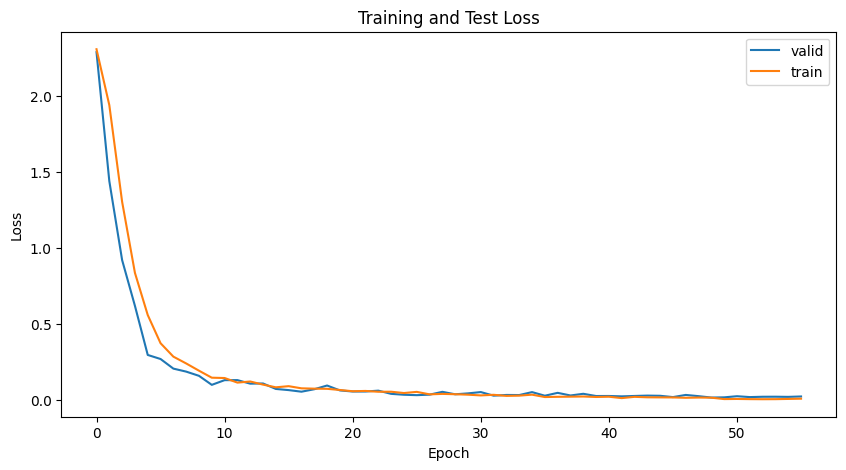

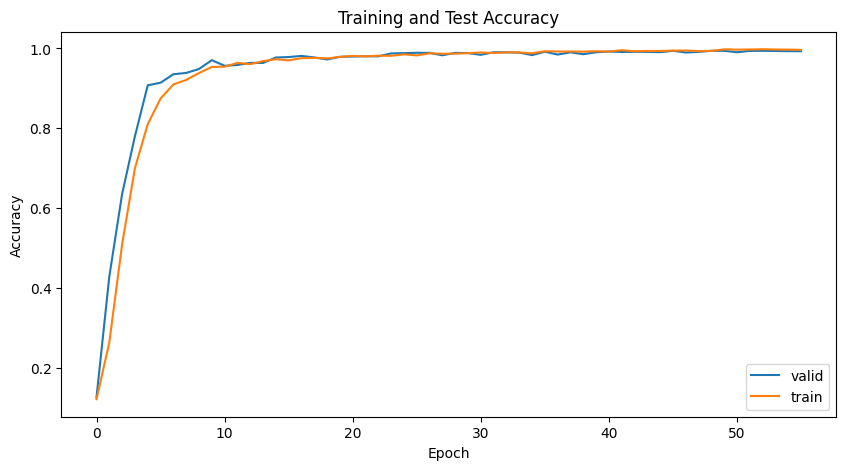

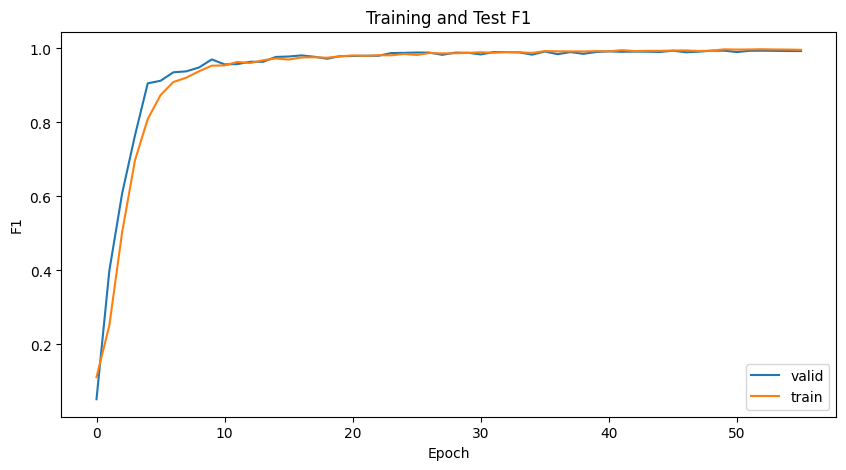

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def inference(test_loader, model, model_name, config):
    if model_name == 'resnet50' or model_name == 'resnet101':
        model.fc = nn.Linear(2048, 10)
    elif model_name == 'cvt_3' or model_name == 'cvt_7' or model_name == 'cvt_14':
        pass
    else:
        raise NotImplementedError('unknown architecture')
    
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = InferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = inference(test_loader, model, model_name, config)

Inference: 100%|███████████████████████████████████████████████████████████████████| 1246/1246 [19:11<00:00,  1.08it/s]


In [18]:
df.to_csv(f'submission {model_name}.csv', index=False)